# Baseline Price Model — Trend Surgeon (Pharma Sector)

This notebook builds the **baseline price model** for the PPH ETF (Pharmaceutical industry).  
The goal is to:

1. Create simple price-based features  
2. Train a baseline ML classifier
3. Generate two benchmark baselines:
   - **S&P 500 Buy & Hold**
   - **PPH Buy & Hold**
4. Compare our model’s performance to these baselines

This is the foundation for the multi-modal model (Price + Sentiment + Reinforcement Learning) built later.


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

PHARMA_ETF_TICKER = "PPH"
START_DATE = "2018-01-01"
END_DATE = "2022-12-31"

df = yf.download(PHARMA_ETF_TICKER, start=START_DATE, end=END_DATE, auto_adjust=False)

[*********************100%***********************]  1 of 1 completed


In [4]:
#PLACEHOLDER
#mport yfinance as yf
#mport pandas as pd
#mport numpy as np
#mport matplotlib.pyplot as plt
#mport seaborn as sns
#from src.data.load_data import load_price_data

#df = load_price_data("path")
#df.head()


In [5]:
pph = yf.download("PPH", start="2018-01-01")
sp500 = yf.download("^GSPC", start="2018-01-01")

pph.head(), sp500.head()

/var/folders/rv/wn91htk92yj1ly2gywdqh0700000gn/T/ipykernel_20093/398048194.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  pph = yf.download("PPH", start="2018-01-01")
[*********************100%***********************]  1 of 1 completed
/var/folders/rv/wn91htk92yj1ly2gywdqh0700000gn/T/ipykernel_20093/398048194.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="2018-01-01")
[*********************100%***********************]  1 of 1 completed


(Price           Close       High        Low       Open Volume
 Ticker            PPH        PPH        PPH        PPH    PPH
 Date                                                         
 2018-01-02  52.076817  52.076817  51.342733  51.342733  18700
 2018-01-03  52.387733  52.422279  51.964554  52.042281  31800
 2018-01-04  52.612270  52.681362  52.292729  52.569090  15000
 2018-01-05  52.983635  52.983635  52.672731  52.672731  35900
 2018-01-08  52.776360  52.923175  52.353180  52.715906  73000,
 Price             Close         High          Low         Open      Volume
 Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
 Date                                                                      
 2018-01-02  2695.810059  2695.889893  2682.360107  2683.729980  3397430000
 2018-01-03  2713.060059  2714.370117  2697.770020  2697.850098  3544030000
 2018-01-04  2723.989990  2729.290039  2719.070068  2719.310059  3697340000
 2018-01-05  2743.149902  2743.449951  

## Create simple price-based features

For the baseline model, we intentionally use **very simple features**:
- 1-day return
- 5-day volatility
- 10-day moving average
- 20-day moving average
- Volume trend

These features capture basic momentum and volatility patterns and are easy to compute.

This keeps the baseline interpretable and gives us a benchmark for later sophisticated models.

In [6]:
df = pph.copy()

df["return_1d"] = df["Close"].pct_change()
df["vol_5d"] = df["return_1d"].rolling(5).std()
df["ma_10"] = df["Close"].rolling(10).mean()
df["ma_20"] = df["Close"].rolling(20).mean()
df["volume_trend"] = df["Volume"].pct_change()

df.head()

Price,Close,High,Low,Open,Volume,return_1d,vol_5d,ma_10,ma_20,volume_trend
Ticker,PPH,PPH,PPH,PPH,PPH,,,,,
Date,,,,,,,,,,
2018-01-02,52.076817,52.076817,51.342733,51.342733,18700,NaN,NaN,NaN,NaN,NaN
2018-01-03,52.387733,52.422279,51.964554,52.042281,31800,0.005970,NaN,NaN,NaN,0.700535
2018-01-04,52.612270,52.681362,52.292729,52.569090,15000,0.004286,NaN,NaN,NaN,-0.528302
2018-01-05,52.983635,52.983635,52.672731,52.672731,35900,0.007059,NaN,NaN,NaN,1.393333
2018-01-08,52.776360,52.923175,52.353180,52.715906,73000,-0.003912,NaN,NaN,NaN,1.033426


In [7]:
def compute_RSI(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [8]:
def compute_MACD(series, short=12, long=26, signal=9):
    exp1 = series.ewm(span=short, adjust=False).mean()
    exp2 = series.ewm(span=long, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    hist = macd - signal_line
    return macd, signal_line, hist

In [9]:
df["return_5d"] = df["Close"].pct_change(5)
df["return_20d"] = df["Close"].pct_change(20)

df["momentum_20d"] = df["Close"] / df["Close"].shift(20)

df["vol_20d"] = df["return_1d"].rolling(20).std()

df["rsi_14"] = compute_RSI(df["Close"], 14)

df["macd"], df["macd_signal"], df["macd_hist"] = compute_MACD(df["Close"])

## Create the target variable (Up/Down prediction)

We want to predict whether the price will be **higher in 30 trading days**.

Target:
- `1` → price goes up over the next 30 days
- `0` → price goes down over the next 30 days

This makes it a binary classification problem, suitable for logistic regression.

In [10]:
horizon = 30
df["return_next"] = df["Close"].shift(-horizon) / df["Close"] - 1
df["target"] = (df["return_next"] > 0).astype(int)
df = df.dropna()
df.head()

Price,Close,High,Low,Open,Volume,return_1d,vol_5d,ma_10,ma_20,volume_trend,return_5d,return_20d,momentum_20d,vol_20d,rsi_14,macd,macd_signal,macd_hist,return_next,target
Ticker,PPH,PPH,PPH,PPH,PPH,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,
2018-01-31,53.104546,54.304989,52.957727,54.192717,333100,-0.019611,0.017252,54.545939,53.951760,5.393474,-0.025978,0.019735,1.019735,0.010218,51.015274,0.527992,0.611810,-0.083818,-0.046837,0
2018-02-01,53.294537,53.614082,52.543180,52.681361,41400,0.003578,0.016775,54.466486,53.997100,-0.875713,-0.028954,0.017309,1.017309,0.010171,46.089375,0.410286,0.571506,-0.161219,-0.046670,0
2018-02-02,52.396374,53.121822,52.396374,52.819553,19500,-0.016853,0.011414,54.295488,53.986305,-0.528986,-0.060981,-0.004104,0.995896,0.010875,35.611123,0.241743,0.505553,-0.263810,-0.044998,0
2018-02-05,50.176846,52.258191,50.176846,51.938650,117100,-0.042360,0.016463,53.846402,53.845966,5.005128,-0.096142,-0.052975,0.947025,0.014244,26.885016,-0.070118,0.390419,-0.460537,-0.009983,0
2018-02-06,50.815929,50.962745,49.200944,49.200944,54100,0.012737,0.021544,53.467269,53.747944,-0.538002,-0.061862,-0.037146,0.962854,0.014645,29.675662,-0.262673,0.259800,-0.522474,-0.019715,0


## Time-series train/test split (calendar-based)

We follow the project constraints:

### Training period
**2018-01-01 → 2022-12-31**

### Testing period
**2023-01-01 → today**

This structure simulates real-world out-of-sample evaluation.

In [11]:
train = df.loc["2018-01-01":"2022-12-31"].copy()
test = df.loc["2023-01-01":].copy()

features = [
    "return_1d", "return_5d", "return_20d",
    "vol_5d", "vol_20d",
    "ma_10", "ma_20",
    "momentum_20d",
    "volume_trend",
    "rsi_14",
    "macd", "macd_signal", "macd_hist"
]

len(train), len(test)

(1239, 702)

## Train a baseline model

In [12]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

model.fit(
    train[features],
    train["target"],
    eval_set=[(train[features], train["target"]), (test[features], test["target"])],
    verbose=False
)

# Probabilities for the positive class (UP)
proba = model.predict_proba(test[features])[:, 1]

## Build benchmark baselines

We build two reference strategies:

### **Baseline A — PPH Buy & Hold**
Invest in PPH at the start and never sell.
Represents the pharma industry trend.

### **Baseline B — S&P500 Buy & Hold**
Represents the broad equity market.

If our model cannot beat these baselines,
it does not add value.

In [13]:
# PPH Buy & Hold baseline
pph["pph_return"] = pph["Close"].pct_change()
pph["pph_hold"] = (1 + pph["pph_return"]).cumprod()

# S&P 500 Buy & Hold baseline
sp500["sp500_return"] = sp500["Close"].pct_change()
sp500["sp500_hold"] = (1 + sp500["sp500_return"]).cumprod()

## Compute the model’s trading returns

We simulate a simple trading rule:

- If the model predicts **UP**, take a long position  
- If the model predicts **DOWN**, stay out of the market  

This is a simplified baseline strategy,
but enough to compare performance across models.

In [ ]:
# Store XGBoost probabilities (model confidence that price will be UP in 30 days)
test["proba"] = proba

# Trading signal based on probability thresholds
# ---------------------------------------------------
# If the model is strongly confident P(up) > 0.55  → we take a LONG position
# If the model is strongly confident P(up) < 0.45  → we take a SHORT position
# Otherwise                                       → we stay FLAT (do nothing)
#
# These thresholds allow only "high conviction" trades,
# avoiding noise and weak signals in the middle range.

test["signal"] = 0
test.loc[test["proba"] > 0.55, "signal"] = 1     # Go LONG
test.loc[test["proba"] < 0.45, "signal"] = -1    # Go SHORT

# Shift signal by 1 day to avoid look-ahead bias
# ---------------------------------------------------
# We must not trade on the same day we make the prediction.
# The model predicts today → we execute the trade tomorrow.
#
# If we don't shift the signal, we accidentally use future information.

test["signal_shifted"] = test["signal"].shift(1).fillna(0)

# Compute strategy return based on 30-day future returns
# ---------------------------------------------------
# IMPORTANT: Since the model predicts 30-day returns,
# we must trade using "return_next", not daily returns.
#
# strategy_return = (future 30-day return) * (position we take today)

test["strategy_return"] = test["return_next"] * test["signal_shifted"]

# Cumulative strategy performance
test["strategy_cum"] = (1 + test["strategy_return"]).cumprod()

## Plot comparison of all strategies

This chart is essential for evaluating the baseline:

- Does the ML model outperform PPH Buy & Hold?
- Does it outperform the S&P 500?
- Does it show stability or volatility?

This plot will be used in the final project presentation.

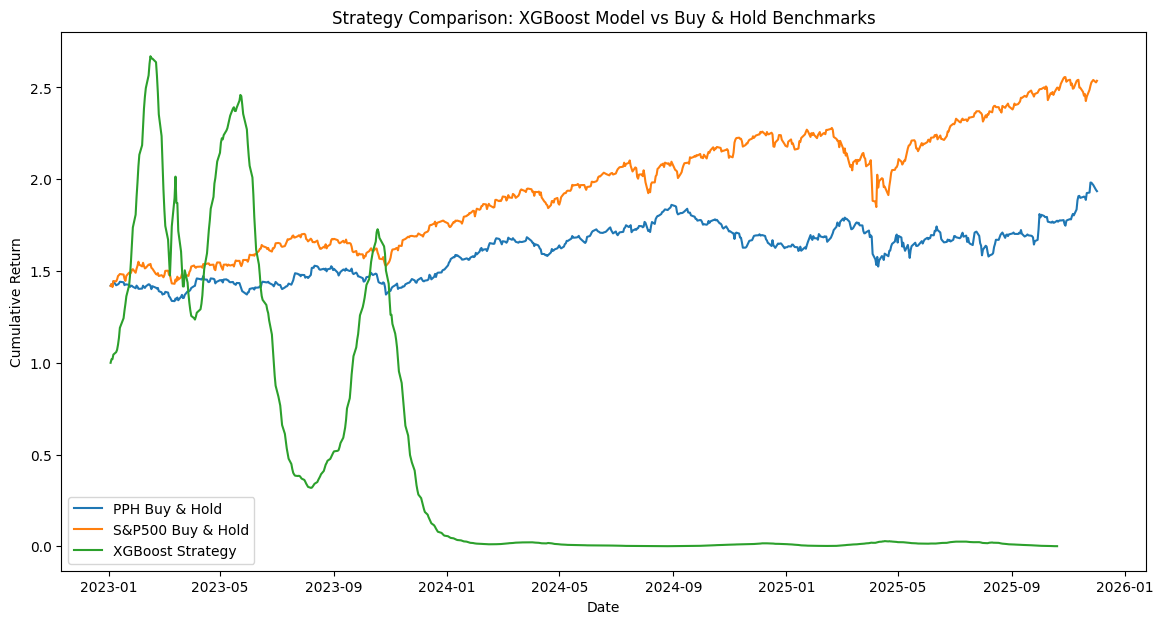

In [21]:
pph_test = pph.loc["2023-01-01":]
sp500_test = sp500.loc["2023-01-01":]

plt.figure(figsize=(14,7))
plt.plot(pph_test.index, pph_test["pph_hold"], label="PPH Buy & Hold")
plt.plot(sp500_test.index, sp500_test["sp500_hold"], label="S&P500 Buy & Hold")
plt.plot(test.index, test["strategy_cum"], label="XGBoost Strategy")

plt.legend()
plt.title("Strategy Comparison: XGBoost Model vs Buy & Hold Benchmarks")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.show()